## Supervised Learning Practice

Hi...

I'd like to demonstrate how I predict survival on titanic dataset, and trying to improve the accuracy.
Feel free to contribute.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [3]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Cleaning the Data and EDA

- I'd like to remove Cabin column due to the null value is so huge. I assume it will be hard to apply machine learning or other prediction method to do data imputation.
- I'll use mode of Embarked column to to imputation. It's clear enough because Embarked column is categorical data.
- Before I do some imputation method at Age column, it'll better to visualize the distribution so I can decide the imputation method correctly.
- Also, I'd like to remove Name and Ticket columns, because the data is too unique. And I assume we don't have much information from those columns.

In [4]:
# remove cabin, name and ticket
df.drop(['Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

# embarked column imputation
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

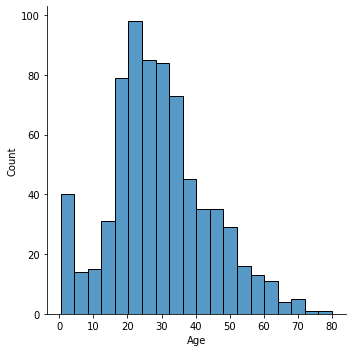

In [5]:
import seaborn as sns
%matplotlib inline

sns.displot(df, x='Age')

The distribution is positive skew, so it's better to use median to imputation.

In [6]:
# age column imputation
df['Age'].fillna(df['Age'].median(), inplace=True)

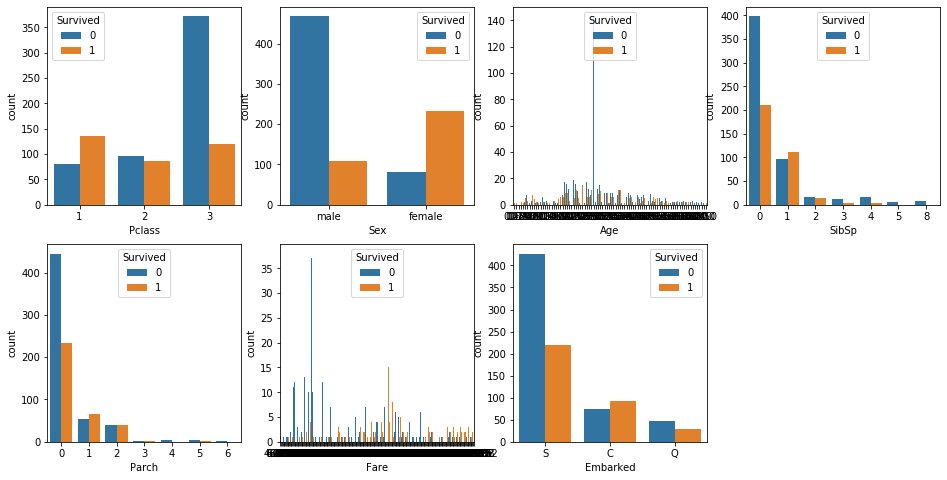

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
title = df.columns[1:].to_list()
for i in range(7):
    plt.subplot(2,4,i+1)
    sns.countplot(x=title[i], hue='Survived', data=df)

From this point, we can make another assumption

- Based on passenger's sex, male is likely to die and female is likely to survive.
- Passenger with passenger class 3 is likely to die, but we cannot make assumption on another classes.
- Passenger with no sibling or spouse is likely to die than passenger who have sibling or spouse.
- Passenger with parent and children have the same condition.
- Passenger who embarked from Southampton is more likely to die (I don't know why?).

More details on Age and Fare

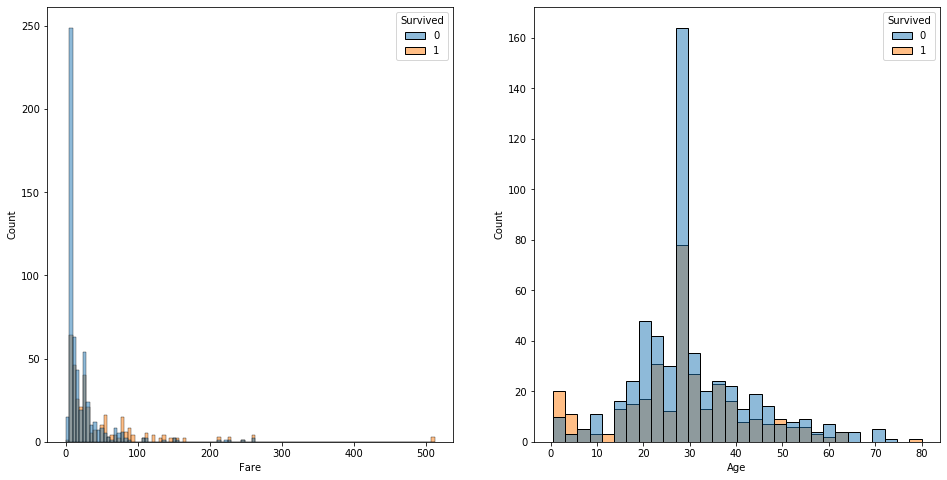

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.histplot(df, x='Fare', hue='Survived')

plt.subplot(1,2,2)
sns.histplot(df, x='Age', hue='Survived')

### Feature Engineering and Selection

In [9]:
df['sex_male'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['sex_female'] = df['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df.drop('Sex', axis=1, inplace=True)

In [10]:
df['embarked_S'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df['embarked_C'] = df['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df['embarked_Q'] = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df.drop('Embarked', axis=1, inplace=True)

In [11]:
df_ = pd.read_csv('../data/test.csv')
df_['sex_male'] = df_['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df_['sex_female'] = df_['Sex'].apply(lambda x: 1 if x == 'female' else 0)
df_.drop('Sex', axis=1, inplace=True)

In [12]:
df_['embarked_S'] = df_['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
df_['embarked_C'] = df_['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
df_['embarked_Q'] = df_['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
df_.drop('Embarked', axis=1, inplace=True)

In [13]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,sex_male,sex_female,embarked_S,embarked_C,embarked_Q
PassengerId,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,0,0
2,1,1,38.0,1,0,71.2833,0,1,0,1,0
3,1,3,26.0,0,0,7.9250,0,1,1,0,0
4,1,1,35.0,1,0,53.1000,0,1,1,0,0
5,0,3,35.0,0,0,8.0500,1,0,1,0,0


### Modeling
#### Benchmark: predict all dead or all survived

The simplest strategy to get a benchmark score. In the next modeling which should be more complex, the score have to be higher than benchmark.

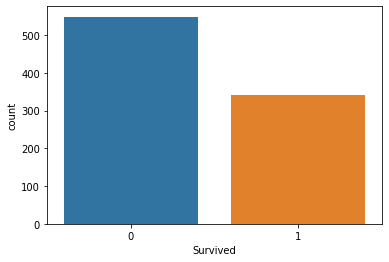

In [14]:
sns.countplot(x='Survived', data=df)

Since died is the majority, I will submit all died for benchmark.

In [15]:
df_test = pd.read_csv('../data/test.csv')
mod1 = df_test.copy()
mod1['Survived'] = 0
mod1 = mod1.loc[:,['PassengerId', 'Survived']]

In [16]:
# I got this data submission with 100% accuracy from kaggle
df_score = pd.read_csv('../data/sub_titanic.csv')

In [17]:
acc = mod1.merge(df_score, how='inner', on='PassengerId')
acc['score'] = acc.apply(lambda x: 1 if x['Survived_x'] == x['Survived_y'] else 0, axis=1)
print('Benchmark score:')
acc['score'].sum()/acc['score'].count()*100

Benchmark score:


62.20095693779905

I got model accuracy 62% just by submitting all passenger die.

#### Decision Tree

In [18]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

feature = ['Pclass', 'SibSp', 'Parch', 'sex_male', 'sex_female', 'embarked_S', 'embarked_C', 'embarked_Q']

X_train = df.loc[:, feature].values
y_train = df.loc[:, 'Survived'].values
X_test = df_.loc[:, feature].values
y_test = df_score.loc[:, 'Survived'].values

In [19]:
# Train the model
clf = clf.fit(X_train, y_train)

# predict
clf.predict(X_test)

# scoring
print('Decision Tree Score:')
clf.score(X_test, y_test)*100

Decision Tree Score:


75.83732057416267

With improvement score until 76%, I can conclude decision tree is a better model than benchmark. Next improvement, I try random forest model.

#### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000)

# Train the model
rf.fit(X_train, y_train)

# predict
rf.predict(X_test)

# scoring
print('Random Forest Score:')
rf.score(X_test, y_test)*100

Random Forest Score:


76.55502392344498

The random forest model performed better but had less impact.